## 🛡️ SensorGuard - Failure Prediction Modeling
This notebook performs end-to-end modeling for predicting machine failure within 7 days.

#### 📥 Import required libraries and load Dataset

In [24]:
import joblib
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score
)
from sklearn.feature_selection import VarianceThreshold

In [2]:
csv_path = "../data/factory_sensor_simulator_2040.csv"

try:
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"❌ File not found: {csv_path}")
    df = pd.read_csv(csv_path, low_memory=False)
    print("✅ CSV file loaded successfully.")
    display(df.head())  # pour notebook
except FileNotFoundError as e:
    print(e)

✅ CSV file loaded successfully.


,Machine_ID,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,...,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,Laser_Intensity,Hydraulic_Pressure_bar,Coolant_Flow_L_min,Heat_Index,AI_Override_Events
0,MC_000000,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,...,5,True,3,162.0,False,NaN,NaN,NaN,NaN,2
1,MC_000001,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,...,2,True,4,147.0,False,NaN,NaN,40.92,NaN,2
2,MC_000002,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,...,1,True,6,0.0,True,NaN,NaN,NaN,NaN,2
3,MC_000003,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,...,1,False,4,161.0,False,NaN,NaN,NaN,NaN,0
4,MC_000004,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,...,2,False,1,765.0,False,NaN,NaN,NaN,NaN,0


#### 🧹 Data Cleaning

##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Remove High-Missing Columns*

In [3]:
# Drop columns with more than 30% missing values to clean up the feature space.
missing_ratio = df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.3].index.tolist()
df.drop(columns=cols_to_drop, inplace=True)
print(f"🗑️ Dropped columns with >30% missing values: {cols_to_drop}")

🗑️ Dropped columns with >30% missing values: ['Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min', 'Heat_Index']


##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Drop Incomplete Rows*

In [4]:
# Drop rows with any remaining missing values to ensure model-ready data
before_rows = df.shape[0]
df.dropna(inplace=True)
after_rows = df.shape[0]
print(f"🧹 Removed {before_rows - after_rows} rows with missing values.")

🧹 Removed 10 rows with missing values.


##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Normalize Data Types*

In [5]:
# 1- Convert boolean columns to integers for model compatibility
converted_bool_cols = []
for col in df.columns:
    if df[col].dropna().isin([True, False]).all():
        df[col] = df[col].astype(bool).astype(int)
        converted_bool_cols.append(col)
        print(f"🔁 Replace boolean, target {col} unique values:", df[col].unique())

# 2- Identify float columns containing only integer values
float_cols = df.select_dtypes(include=["float"]).columns

float_to_int_candidates = []
for col in float_cols:
    if df[col].dropna().apply(float.is_integer).all():
        float_to_int_candidates.append(col)

if float_to_int_candidates:
    print(f"🔁 Float columns with only integer values converted: {float_to_int_candidates}")
    df[float_to_int_candidates] = df[float_to_int_candidates].astype("int")

🔁 Replace boolean, target AI_Supervision unique values: [1 0]
🔁 Replace boolean, target Failure_Within_7_Days unique values: [0 1]
🔁 Float columns with only integer values converted: ['Remaining_Useful_Life_days']


##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Cleaned Dataset Overview*

In [6]:
print("✅ Cleaned dataset summary:")
print(f"   🔸 Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"   🔸 Dropped columns: {cols_to_drop}")
print(f"   🔸 Number of dropped rows: {before_rows - after_rows}")
print(f"   🔸 Converted boolean columns (as int): {converted_bool_cols}")

display(df.head())

✅ Cleaned dataset summary:
   🔸 Shape: 499990 rows × 18 columns
   🔸 Dropped columns: ['Laser_Intensity', 'Hydraulic_Pressure_bar', 'Coolant_Flow_L_min', 'Heat_Index']
   🔸 Number of dropped rows: 10
   🔸 Converted boolean columns (as int): ['AI_Supervision', 'Failure_Within_7_Days']


,Machine_ID,Machine_Type,Installation_Year,Operational_Hours,Temperature_C,Vibration_mms,Sound_dB,Oil_Level_pct,Coolant_Level_pct,Power_Consumption_kW,Last_Maintenance_Days_Ago,Maintenance_History_Count,Failure_History_Count,AI_Supervision,Error_Codes_Last_30_Days,Remaining_Useful_Life_days,Failure_Within_7_Days,AI_Override_Events
0,MC_000000,Mixer,2027,81769,73.43,12.78,83.72,36.76,68.74,84.95,153,4,5,1,3,162,0,2
1,MC_000001,Industrial_Chiller,2032,74966,58.32,14.99,77.04,100.00,62.13,154.61,136,5,2,1,4,147,0,2
2,MC_000002,Pick_and_Place,2003,94006,49.63,23.78,69.08,42.96,35.96,51.90,258,1,1,1,6,0,1,2
3,MC_000003,Vision_System,2007,76637,63.73,12.38,85.58,94.90,48.94,75.61,43,4,1,0,4,161,0,0
4,MC_000004,Shuttle_System,2016,20870,42.77,4.42,96.72,47.56,53.78,224.93,346,4,2,0,1,765,0,0


#### ⚖️ Handle Class Distribution

##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Check class distribution*

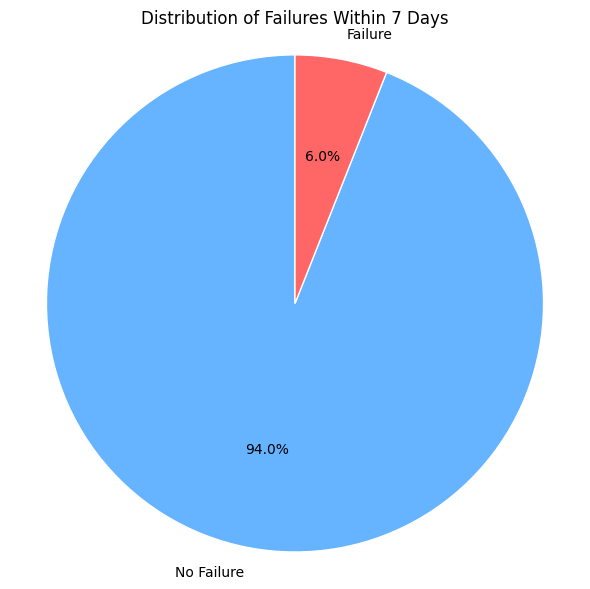

In [7]:
# Visualize class balance with a pie chart
labels = ["No Failure", "Failure"]
sizes = df["Failure_Within_7_Days"].value_counts()
colors = ["#66b3ff", "#ff6666"]

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    wedgeprops={"edgecolor": "white"},
)
plt.title("Distribution of Failures Within 7 Days")
plt.axis("equal")
plt.tight_layout()
plt.show()

##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*We want to reach a balance of 50/50 to ensure that our model will be trained with significant data*

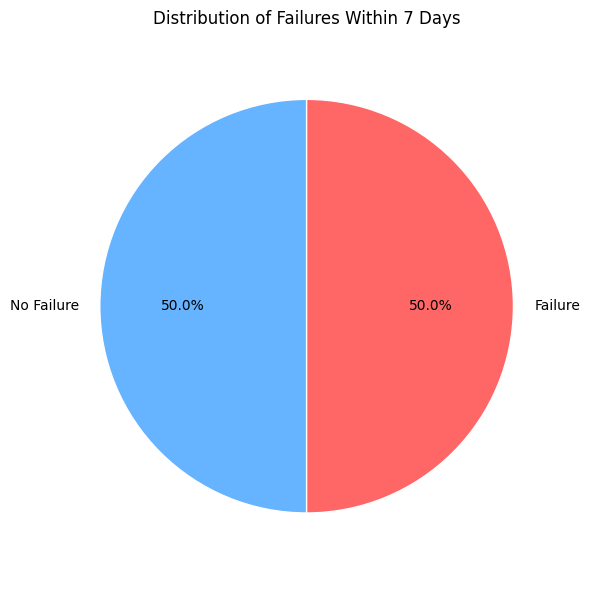

✅ Dataset balanced: Failure_Within_7_Days
0    30027
1    30027
Name: count, dtype: int64
📊 New shape: (60054, 18)


In [8]:
# Balance the dataset to achieve a 50/50 class distribution
count_true = df[df["Failure_Within_7_Days"] == True].shape[0]
count_false = df[df["Failure_Within_7_Days"] == False].shape[0]

# Undersample the majority class (False)
df_false_sampled = df[df["Failure_Within_7_Days"] == False].sample(
    count_true, random_state=42
)
df_true = df[df["Failure_Within_7_Days"] == True]

# Concatenate to get a balanced DataFrame
df = (
    pd.concat([df_false_sampled, df_true])
    .sample(frac=1, random_state=42)
    .reset_index(drop=True)
)

# Visualize class balance with a pie chart
labels = ["No Failure", "Failure"]
sizes = df["Failure_Within_7_Days"].value_counts()
colors = ["#66b3ff", "#ff6666"]

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors,
    startangle=90,
    wedgeprops={"edgecolor": "white"},
)
plt.title("Distribution of Failures Within 7 Days")
plt.axis("equal")
plt.tight_layout()
plt.show()

print(f"✅ Dataset balanced: {df['Failure_Within_7_Days'].value_counts()}")
print("📊 New shape:", df.shape)

#### 📊 Feature Distribution

##### &nbsp;*Visualize the distribution of all numeric features using histograms to better understand the dataset's structure.<br>&nbsp;Understanding the shape and spread of each feature provides valuable context before moving forward with<br>&nbsp;feature selection or model training.*

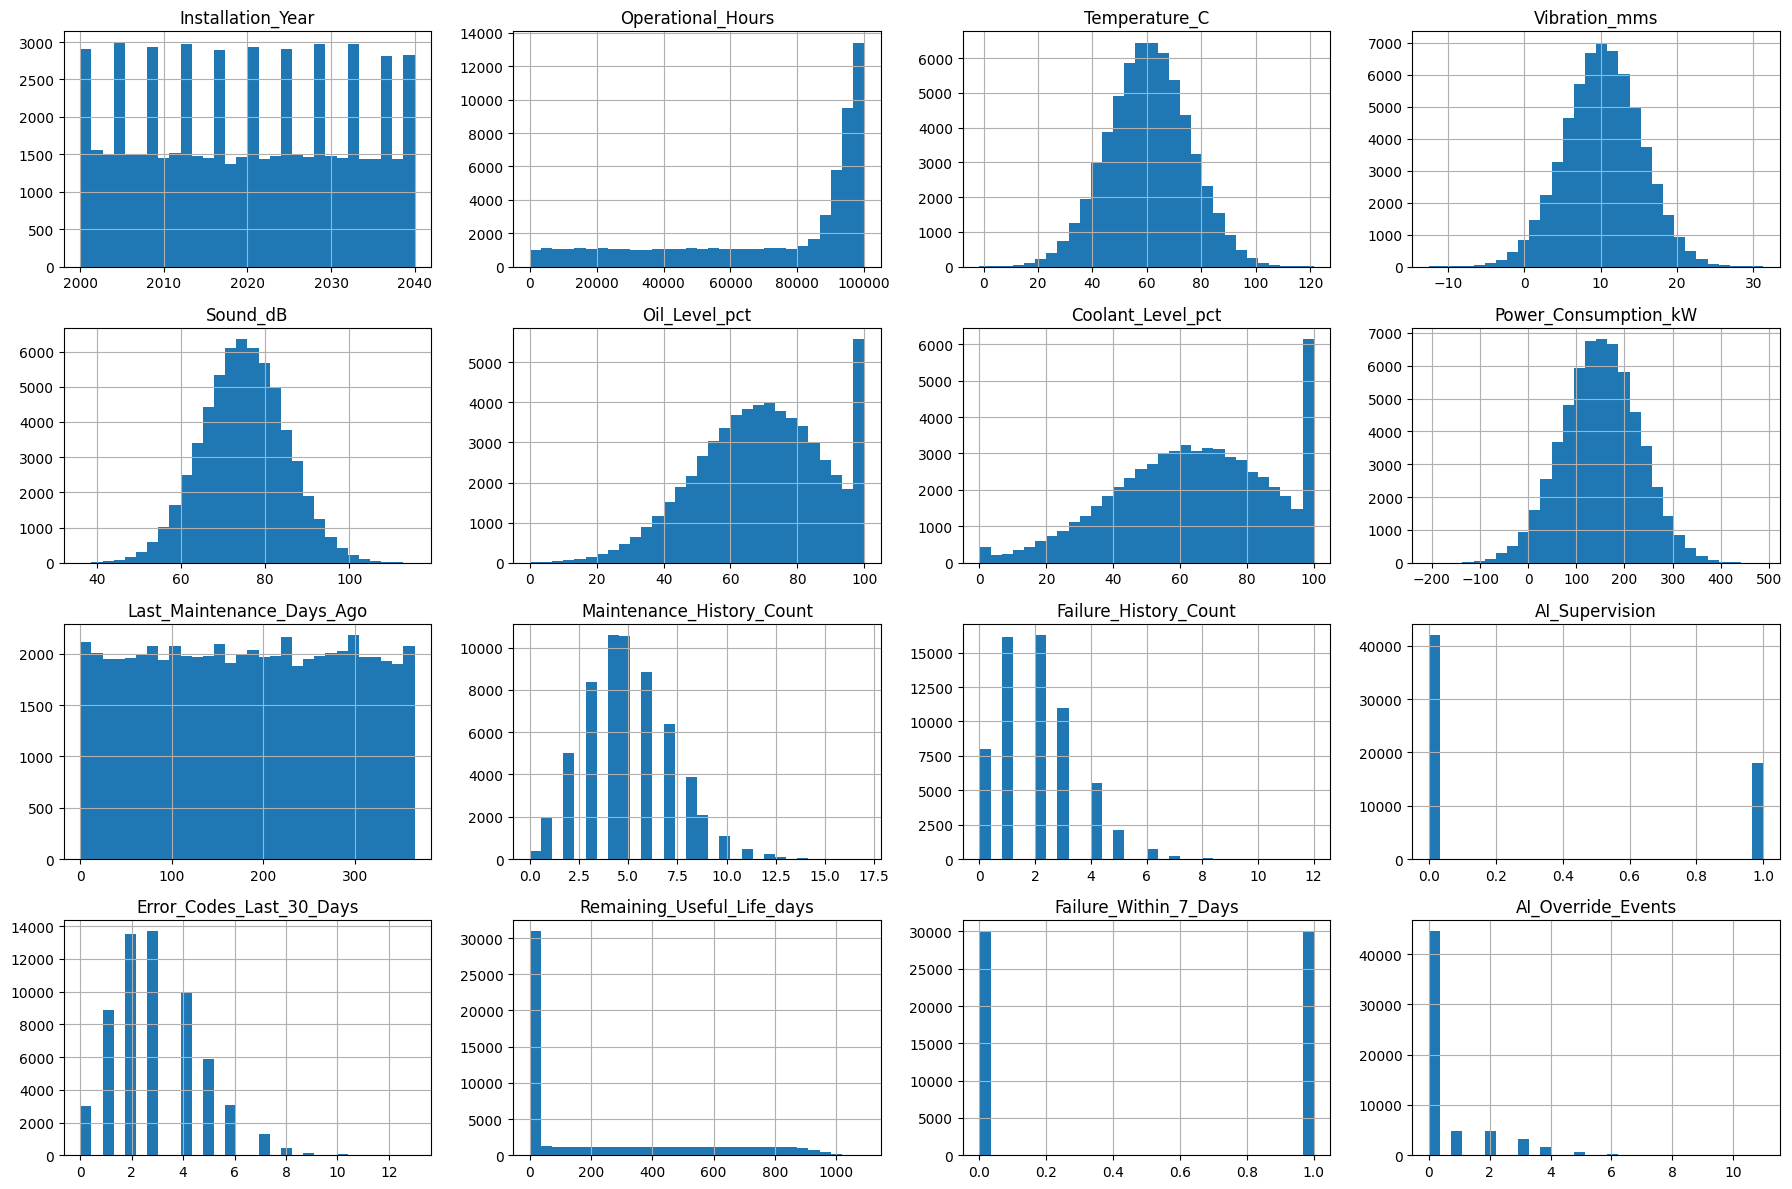

In [9]:
# Plot histograms for numeric features
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].hist(bins=30, figsize=(18, 12))
plt.tight_layout()
plt.show()

#### 📈 Correlation Matrix

##### &nbsp;*Compute and visualize the correlation matrix to examine linear relationships between numeric features.<br>&nbsp;High positive or negative correlations guide feature selection strategies.*

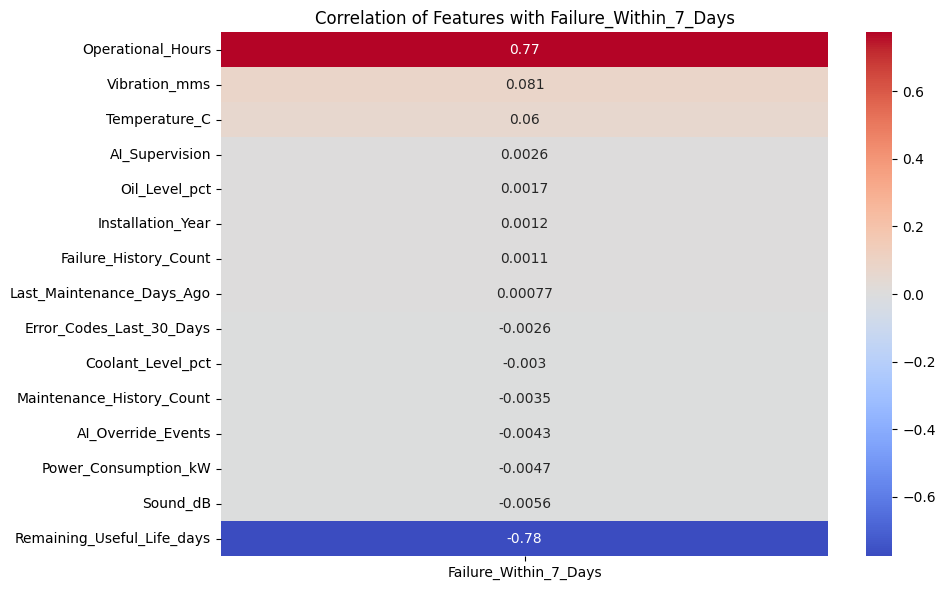

In [10]:
# Compute correlation matrix (numeric only)
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns.drop(
    "Failure_Within_7_Days", errors="ignore"
)
corr_matrix = df[numeric_cols.tolist() + ["Failure_Within_7_Days"]].corr()

# Get correlation of all features with the target
target_corr = corr_matrix["Failure_Within_7_Days"].drop("Failure_Within_7_Days")

# Plot sorted correlations
plt.figure(figsize=(10, 6))
sns.heatmap(
    target_corr.to_frame().sort_values(by="Failure_Within_7_Days", ascending=False),
    annot=True,
    cmap="coolwarm",
)
plt.title("Correlation of Features with Failure_Within_7_Days")
plt.tight_layout()
plt.show()

#### 🎯 Feature Selection thanks to feature coorelation and distribution

##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Remove feature with low variance*

In [ ]:
# Calculate variance for numeric columns
selector = VarianceThreshold(threshold=0.01)
selector.fit(df[numeric_cols])

# Keep only columns with sufficient variance
high_variance_cols = [
    col for col, keep in zip(numeric_cols, selector.get_support()) if keep
]

print("📌 Features retained based on variance threshold (0.01):")
for col in high_variance_cols:
    print(f" - {col}")

# Update dataframe to keep only high-variance features
df = df[high_variance_cols + ["Failure_Within_7_Days"]]

📌 Features retained based on variance threshold (0.01):
 - Installation_Year
 - Operational_Hours
 - Temperature_C
 - Vibration_mms
 - Sound_dB
 - Oil_Level_pct
 - Coolant_Level_pct
 - Power_Consumption_kW
 - Last_Maintenance_Days_Ago
 - Maintenance_History_Count
 - Failure_History_Count
 - AI_Supervision
 - Error_Codes_Last_30_Days
 - Remaining_Useful_Life_days
 - AI_Override_Events


##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Prevent Data Leakage: Remove Proxy Features*

In [12]:
# Exclude leakage-prone features
leakage_features = ["Remaining_Useful_Life_days"]
target_corr = target_corr.drop(labels=leakage_features, errors="ignore")

##### 🔹 &nbsp;&nbsp;&nbsp;&nbsp;*Select relevant features based on correlation with target*

In [13]:
# Select features above correlation threshold
corr_threshold = 0.05
relevant_features = (
    target_corr[abs(target_corr) > corr_threshold]
    .sort_values(ascending=False)
    .index.tolist()
)

# Define features and target
features = relevant_features
X = df[features]
y = df["Failure_Within_7_Days"]

# Display selected features and their correlation
print("📌 Features selected based on correlation > 0.05:")
for feat in features:
    print(f" - {feat} (corr = {target_corr[feat]:.3f})")
print(f"\n✅ Total features selected: {len(features)}: {features}")

📌 Features selected based on correlation > 0.05:
 - Operational_Hours (corr = 0.775)
 - Vibration_mms (corr = 0.081)
 - Temperature_C (corr = 0.060)

✅ Total features selected: 3: ['Operational_Hours', 'Vibration_mms', 'Temperature_C']


#### ✂️ Data Split and Scaling

##### &nbsp;*The dataset is split into 80% training and 20% testing sets using stratified sampling.<br>&nbsp;Then apply standard scaling, fitting the scaler only on the training data and applying it to both sets to prevent data leakage.*

In [14]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

####  🏋️ Model Training and Evaluation

##### &nbsp;*We selected Logistic Regression, Support Vector Machine (SVM), and Random Forest for this<br>&nbsp;binary classification task for their complementary strengths:*

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- ***Logistic Regression*** is a simple, interpretable, and effective baseline model for binary classification. It allows us to understand the relationship between the input<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;features and the target, and serves as a solid benchmark for performance comparison.

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- ***Support Vector Machine (SVM)*** is well-suited for binary classification with small to medium-sized datasets and few features. It is effective in high-dimensional spaces<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;and robust to outliers, especially when using a linear or RBF kernel. SVMs often yield strong performance on well-separated classes and can handle imbalanced data<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;with appropriate class weighting.

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- ***Random Forest*** reduces variance through ensemble averaging and handles complex decision boundaries without requiring feature linear assumptions.<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It performs well with limited feature sets and provides feature importance insights useful for diagnostics and model interpretation.


🎯 Training Logistic Regression...

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      6006
           1       0.92      0.97      0.95      6005

    accuracy                           0.95     12011
   macro avg       0.95      0.95      0.95     12011
weighted avg       0.95      0.95      0.95     12011



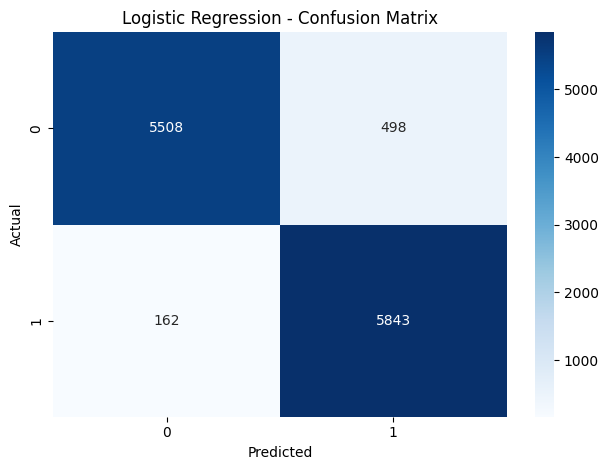

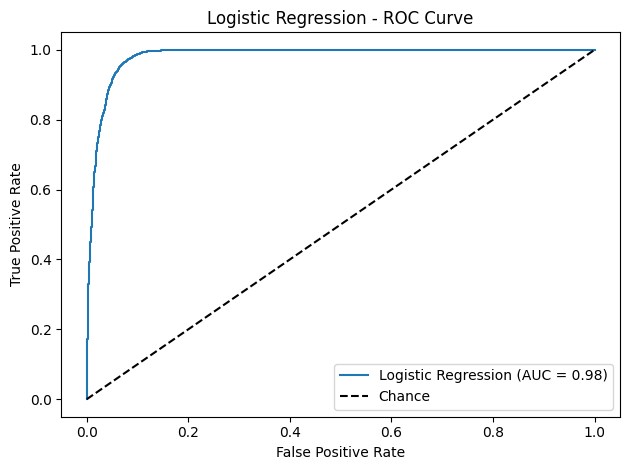


🎯 Training Support Vector Machine...

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      6006
           1       0.92      0.98      0.95      6005

    accuracy                           0.94     12011
   macro avg       0.95      0.94      0.94     12011
weighted avg       0.95      0.94      0.94     12011



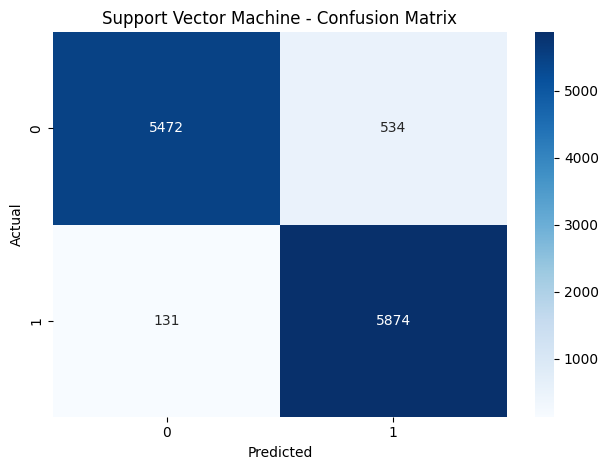

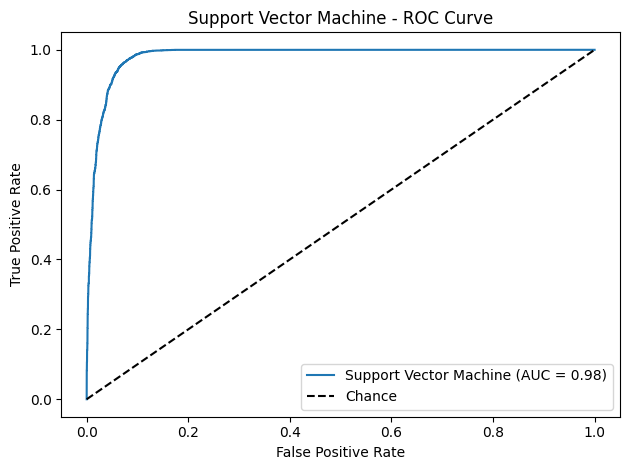


🎯 Training Random Forest...

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      6006
           1       0.92      0.97      0.94      6005

    accuracy                           0.94     12011
   macro avg       0.94      0.94      0.94     12011
weighted avg       0.94      0.94      0.94     12011



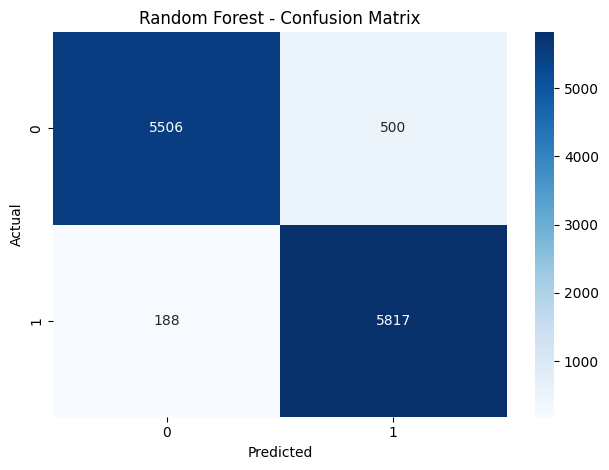

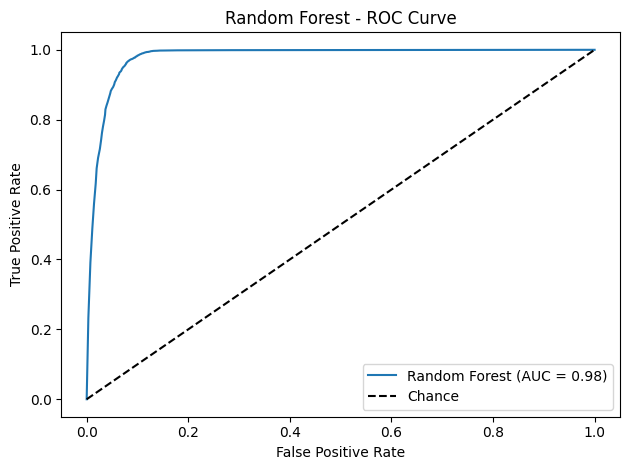

In [15]:
# Define candidate models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(kernel="linear", probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}

model_scores = {}
trained_models = {}

for name, model in models.items():
    print(f"\n🎯 Training {name}...\n")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Save detailed classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    model_scores[name] = report
    # Save trained model
    trained_models[name] = model

    # Display report
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    y_prob = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

#### 🎯 Model selection

#####  🧠 &nbsp;*Selection Strategy*
###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;🔎 The primary objective is to accurately predict equipment failures within the next 7 days.  Because failures can lead to costly downtime, safety risks, and operational<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;disruptions, early and accurate detection is critical => evaluation and selection are focused specifically on performance for class 1 (failures)

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;***🎯 Prioritization Criteria:***<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Primary: Recall (class 1) — we want to minimize false negatives (i.e., missed failures).<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Secondary: F1-score (class 1) — balances precision and recall to handle imbalanced data.<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;- Tertiary: Precision (class 1) — helps reduce false positives, ensuring alerts are meaningful.





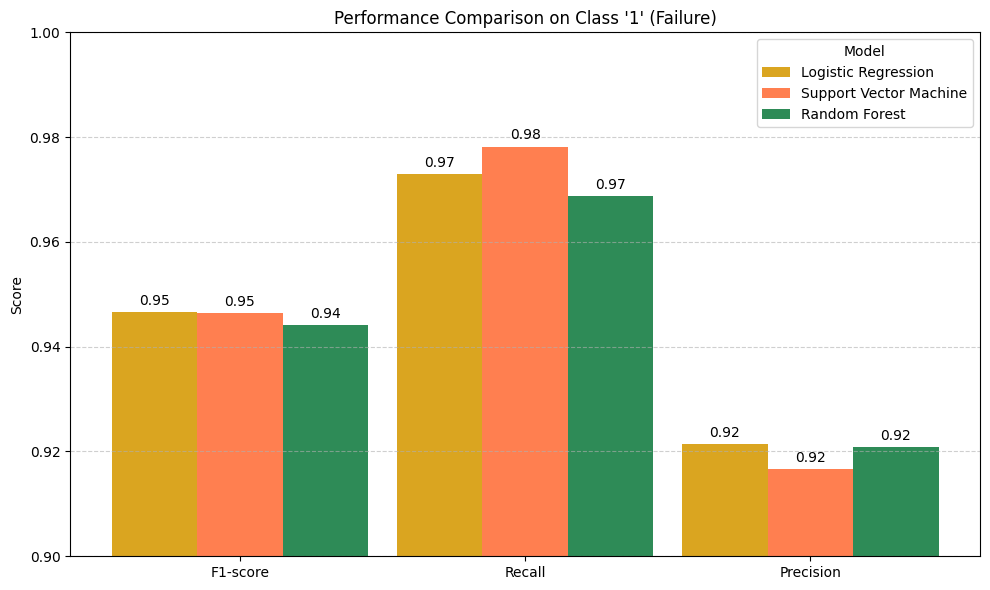

🏆 Selected best model: Support Vector Machine
📈 Recall (class 1): 0.98
📊 F1-score (class 1): 0.95
🔬 Precision (class 1): 0.92


In [16]:
# Display model metrics
metrics = ["f1-score", "recall", "precision"]
model_names = list(model_scores.keys())
scores = {
    metric: [model_scores[model]["1"][metric] for model in model_names]
    for metric in metrics
}

# Plot
x = np.arange(len(metrics))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["goldenrod", "coral", "seagreen"]
rects = []

for i, model_name in enumerate(model_names):
    rect = ax.bar(
        x + (i - 1) * width,
        [scores[m][i] for m in metrics],
        width,
        label=model_name,
        color=colors[i % len(colors)],
    )
    rects.extend(rect)

ax.set_ylabel("Score")
ax.set_title("Performance Comparison on Class '1' (Failure)")
ax.set_xticks(x)
ax.set_xticklabels([m.capitalize() for m in metrics])
ax.set_ylim(0.90, 1.0)
ax.legend(title="Model")
ax.grid(axis="y", linestyle="--", alpha=0.6)

for rect in rects:
    height = rect.get_height()
    ax.annotate(
        f"{height:.2f}",
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

# Select model prioritizing Recall on class '1' (Failures), fallback to F1-score then precision
best_model_name = max(
    model_scores,
    key=lambda name: (
        model_scores[name]["1"].get("recall", 0),
        model_scores[name]["1"].get("f1-score", 0),
        model_scores[name]["1"].get("precision", 0),
    ),
)
best_model = trained_models[best_model_name]

print(f"🏆 Selected best model: {best_model_name}")
print(f"📈 Recall (class 1): {model_scores[best_model_name]['1']['recall']:.2f}")
print(f"📊 F1-score (class 1): {model_scores[best_model_name]['1']['f1-score']:.2f}")
print(f"🔬 Precision (class 1): {model_scores[best_model_name]['1']['precision']:.2f}")

#### 🎚️ Threshold Analysis for Prediction

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Although Support Vector Machines (SVMs) are not inherently probabilistic, enabling probability=True allows us to obtain calibrated probability estimates.<br>      This makes it possible to adjust the decision threshold for classification.<br><br>      Instead of using the default 0.5 cutoff, we analyze the effect of varying the threshold on model performance — particularly ROC AUC — which is crucial<br>      when dealing with imbalanced datasets or when prioritizing recall (e.g., failure detection).

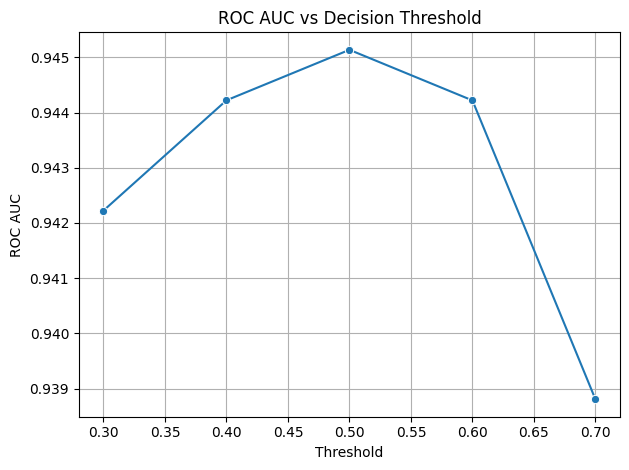

✅ Based on ROC analysis, the default threshold of 0.5 provides optimal balance between precision and recall
No custom threshold adjustment is required.


In [17]:
# Predict probabilities
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

# Try multiple thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
performance = []

for t in thresholds:
    preds = (y_scores > t).astype(int)
    roc_auc = roc_auc_score(y_test, preds)
    performance.append({"Threshold": t, "ROC AUC": roc_auc})

# Plot the results
perf_df = pd.DataFrame(performance)
sns.lineplot(data=perf_df, x="Threshold", y="ROC AUC", marker="o")
plt.title("ROC AUC vs Decision Threshold")
plt.xlabel("Threshold")
plt.ylabel("ROC AUC")
plt.grid(True)
plt.tight_layout()
plt.show()

print(
    "✅ Based on ROC analysis, the default threshold of 0.5 provides optimal balance between precision and recall"
)
print("No custom threshold adjustment is required.")

#### 🧪 Model Fine-Tuning: SVM with Linear and RBF Kernels (Grid Search)

###### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Since SVM achieved the best performance during initial evaluation, we applied hyperparameter tuning using GridSearchCV to further optimize it.<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We tested both linear and RBF kernels, and varied the regularization parameter C. ROC AUC was used as the scoring metric to identify the most effective configuration<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;for detecting failures

Fitting 3 folds for each of 6 candidates, totalling 18 fits


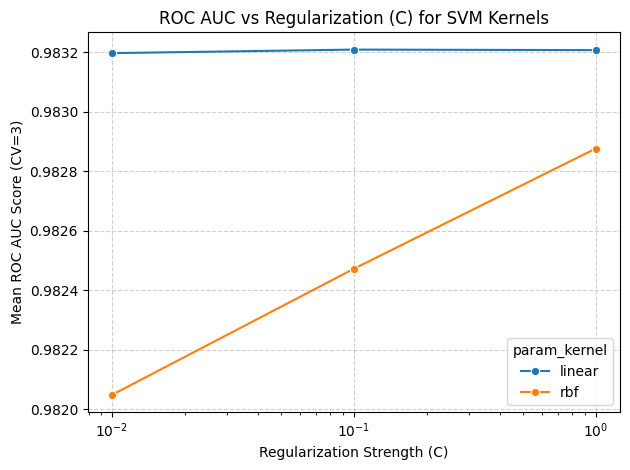

✅ Based on ROC AUC optimization, the best SVM configuration is: C=0.1 with kernel='linear'.


In [18]:
# Define hyperparameter grid including both linear and rbf kernels
param_grid = {
    "C": [0.01, 0.1, 1.0],
    "kernel": ["linear", "rbf"],
}

# Grid search with cross-validation
grid = GridSearchCV(
    SVC(probability=True, class_weight="balanced", random_state=42),
    param_grid,
    cv=3,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1,
)

# Fit the model
grid.fit(X_train_scaled, y_train)

# Select best model
best_model = grid.best_estimator_

# Visualize results
results = pd.DataFrame(grid.cv_results_)

sns.lineplot(
    data=results,
    x="param_C",
    y="mean_test_score",
    hue="param_kernel",
    marker="o"
)
plt.title("ROC AUC vs Regularization (C) for SVM Kernels")
plt.xlabel("Regularization Strength (C)")
plt.ylabel("Mean ROC AUC Score (CV=3)")
plt.xscale("log")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

print(
    f"✅ Based on ROC AUC optimization, the best SVM configuration is: "
    f"C={grid.best_params_['C']} with kernel='{grid.best_params_['kernel']}'."
)

#### 📈 ROC Curve for Tuned SVM

📈 The ROC curve shows the trade-off between true positive rate (recall) and false positive rate at various thresholds.
✅ AUC (Area Under Curve) summarizes the model’s ability to distinguish between classes. Closer to 1.0 = better.


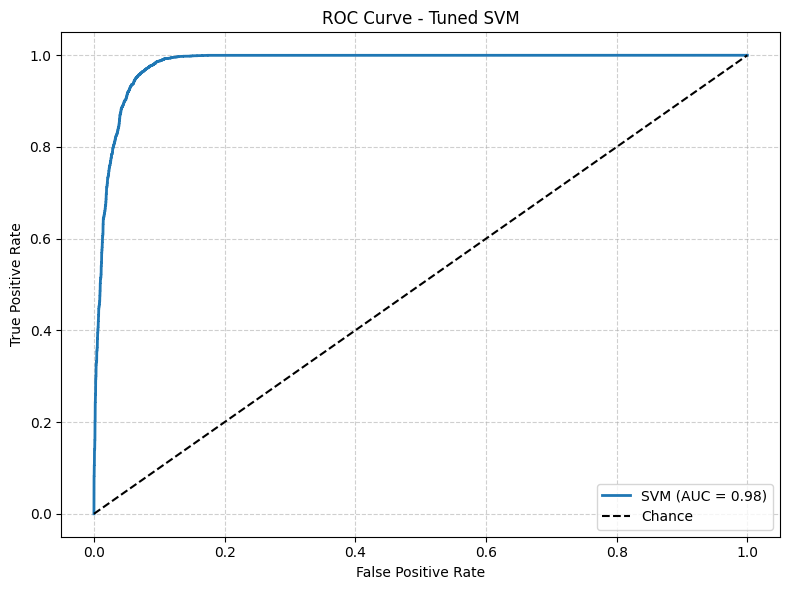

📊 The Precision-Recall curve shows the trade-off between catching failures (recall) and limiting false alarms (precision).
✅ Useful in imbalanced classification problems like failure prediction.


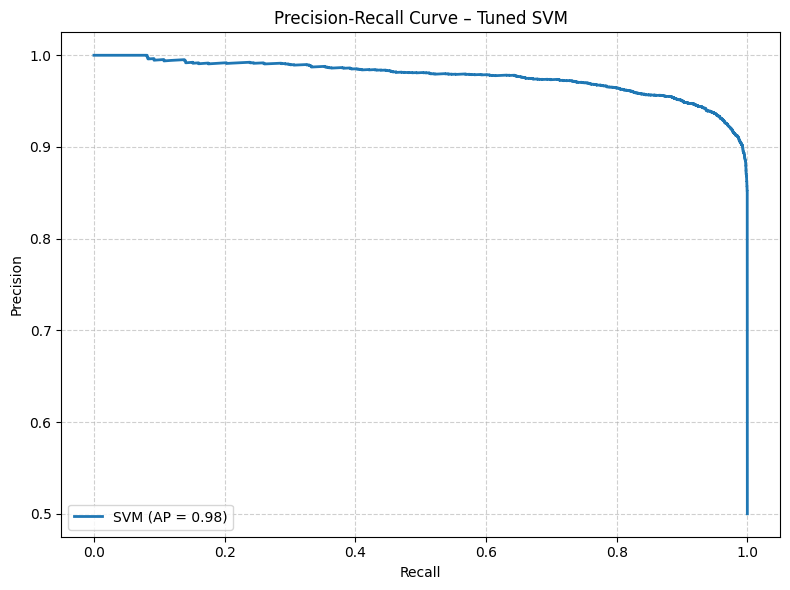

In [25]:
# Get predicted probabilities for class 1
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve and AUC
print("📈 The ROC curve shows the trade-off between true positive rate (recall) and false positive rate at various thresholds.")
print("✅ AUC (Area Under Curve) summarizes the model’s ability to distinguish between classes. Closer to 1.0 = better.")
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"SVM (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Tuned SVM")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Compute precision-recall pairs and average precision
print("📊 The Precision-Recall curve shows the trade-off between catching failures (recall) and limiting false alarms (precision).")
print("✅ Useful in imbalanced classification problems like failure prediction.")
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"SVM (AP = {avg_precision:.2f})", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Tuned SVM")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


####  💾 Save Best Model (optimized with GridSearch) and its scaler

In [20]:
# Create models/ directory if it doesn't exist
os.makedirs("../models", exist_ok=True)

# Evaluation report
y_pred = best_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Save the trained model
model_path = (
    f'../models/failure_predictor_{best_model_name.replace(" ", "_").lower()}.pkl'
)
joblib.dump(best_model, model_path)
print(f"\n✅ Best model ({best_model_name}) saved to: {model_path}")

# Save the fitted scaler as well
scaler_path = "../models/scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Scaler saved to: {scaler_path}")

              precision    recall  f1-score   support

           0       0.98      0.91      0.94      6006
           1       0.91      0.98      0.95      6005

    accuracy                           0.94     12011
   macro avg       0.95      0.94      0.94     12011
weighted avg       0.95      0.94      0.94     12011


✅ Best model (Support Vector Machine) saved to: ../models/failure_predictor_support_vector_machine.pkl
✅ Scaler saved to: ../models/scaler.pkl
